In [57]:
import os
import torch
import pandas as pd
import itertools
import numpy as np
import ipywidgets as widgets
from napatrackmater.Trackvector import (
    SHAPE_DYNAMIC_FEATURES
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import seaborn as sns

In [32]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tracklet_length = 25
normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
n_components = 5

class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_.csv


In [112]:
all_trackmate_ids = [trackid  for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
variance_summary = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for time_point in unique_time_points:
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]

    for cell_type in class_map_gbr.values():
        cell_type_data = time_data[time_data['Cell_Type'] == cell_type]

        if not cell_type_data.empty:
            
            features_list = []
            track_id_list = []  # Lookup table for track IDs
            
            for track_id in cell_type_data['Track ID'].unique():
                track_features = cell_type_data[cell_type_data['Track ID'] == track_id][SHAPE_DYNAMIC_FEATURES].to_numpy()
                features_list.append(track_features)
                track_id_list.extend([track_id] * track_features.shape[0])  # Keep track ID for each row

            concatenated_features = np.vstack(features_list)
            
            if concatenated_features.shape[0] > n_components:  
                pca = PCA(n_components=n_components)
                principal_components = pca.fit_transform(concatenated_features)
                explained_variance = pca.explained_variance_ratio_

                # Store the total variance explained for each cell type and time point
                total_variance_explained = sum(explained_variance)
                if time_point not in variance_summary[cell_type]:
                    variance_summary[cell_type][time_point] = total_variance_explained

                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = []

                # Append PCA result and track ID mapping
                result_dict[cell_type][time_point].append({
                    'principal_components': principal_components,
                    'track_ids': track_id_list  
                })
print(variance_summary)






{'Basal': {0.0: 0.9573333100774546, 1.0: 0.818288171777295, 2.0: 0.8283276919656026, 3.0: 0.8103065645191493, 4.0: 0.7985786197640172, 5.0: 0.8226431093030371, 6.0: 0.8189837694381865, 7.0: 0.8208909112482398, 8.0: 0.7844688676256167, 9.0: 0.8222059726658146, 10.0: 0.8018487779760417, 11.0: 0.7938505095290503, 12.0: 0.7721609077112586, 13.0: 0.7837398387962811, 14.0: 0.7973818211507671, 15.0: 0.7375080627259717, 16.0: 0.765832240505931, 17.0: 0.8104427816480081, 18.0: 0.7929216069499313, 19.0: 0.7795488467919794, 20.0: 0.8122176722868204, 21.0: 0.7539550854423784, 22.0: 0.8195108486675785, 23.0: 0.7813585395328373, 24.0: 0.7798165879644928, 25.0: 0.8174726314463373, 26.0: 0.8247168770436131, 27.0: 0.8229887222078509, 28.0: 0.8237766860927316, 29.0: 0.8458164112738243, 30.0: 0.8336619512188885, 31.0: 0.782601831549243, 32.0: 0.795449704731963, 33.0: 0.7921237504406154, 34.0: 0.796558197268548, 35.0: 0.7627937356669537, 36.0: 0.800141809620932, 37.0: 0.8111133978974427, 38.0: 0.819258932

In [124]:
derivative_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
derivative_square_dict = {cell_type: {} for cell_type in class_map_gbr.values()}

norm_diff_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
for cell_type in class_map_gbr.values():

    for time_idx, time_point in enumerate(unique_time_points[:-1]):  # Skip last time point
        next_time_point = unique_time_points[time_idx + 1]

        if time_point in result_dict[cell_type] and next_time_point in result_dict[cell_type]:
            # Extract the PCA results and track IDs for both time points
            curr_data = result_dict[cell_type][time_point][0]
            next_data = result_dict[cell_type][next_time_point][0]

            curr_features = curr_data['principal_components']  # (N, F)
            next_features = next_data['principal_components']  # (M, F)

            curr_track_ids = np.array(curr_data['track_ids'])  # (N,)
            next_track_ids = np.array(next_data['track_ids'])  # (M,)

            # Find matching track IDs between the two time points
            common_track_ids, curr_indices, next_indices = np.intersect1d(
                curr_track_ids, next_track_ids, return_indices=True
            )

            if len(common_track_ids) == 0:
                continue  # Skip if no matching track IDs

            # Align the features to the exact same track IDs using indices
            aligned_curr_features = curr_features[curr_indices]
            aligned_next_features = next_features[next_indices]

            # Compute the norm differences
            curr_norms = np.linalg.norm(aligned_curr_features, axis=1)  # Norms of current features
            next_norms = np.linalg.norm(aligned_next_features, axis=1)  # Norms of next features
            norm_differences = next_norms - curr_norms

            # Compute the time derivative
            time_derivative = aligned_next_features - aligned_curr_features

            # Initialize dictionaries if they don't exist for the time point
            if time_point not in derivative_dict[cell_type]:
                derivative_dict[cell_type][time_point] = []
                derivative_square_dict[cell_type][time_point] = []
                norm_diff_dict[cell_type][time_point] = []

            # Store the derivatives and norm differences
            derivative_dict[cell_type][time_point].append({'principal_components': time_derivative, 'track_id_list': next_features })
            derivative_square_dict[cell_type][time_point].append({ 'principal_components': time_derivative * time_derivative * 0.5, 'track_id_list': next_features  })
            norm_diff_dict[cell_type][time_point].append({ 'principal_components': norm_differences, 'track_id_list': next_features  })


In [131]:

def plot_pcs_density_and_stats(result_dict, class_map_gbr, n_components=5, selected_pc=1, title='Density and Stats of PC1 Across Cell Types'):
    if selected_pc < 1 or selected_pc > n_components:
        print(f"Invalid principal component number. Please choose a number between 1 and {n_components}.")
        return

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    # Set up the subplot grid
    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    # Flatten axes for easy iteration
    axes = axes.reshape(-1, 3)

    # Loop over each cell type and plot its density and stats
    for idx, cell_type in enumerate(cell_types):
        # Density Plot
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)

            pc_values = pcs[:, selected_pc - 1]

            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f'Density of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'PC{selected_pc} Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        # Variance Plot (Line Plot)
        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)
            pc_values = pcs[:, selected_pc - 1]

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))

        # Plot variance using lineplot (instead of errorbar)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'PC{selected_pc} Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'PC{selected_pc} Mean', fontsize=12)

    # Turn off unused subplots
    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    # Add a global title
    fig.suptitle(title, fontsize=16)
    plt.show()

def plot_norm_diff(result_dict, class_map_gbr, title='Density and Stats of PC1 Across Cell Types'):
   

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    # Set up the subplot grid
    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    # Flatten axes for easy iteration
    axes = axes.reshape(-1, 3)

    # Loop over each cell type and plot its density and stats
    for idx, cell_type in enumerate(cell_types):
        # Density Plot
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pc_values = data['principal_components']  # (N, F)
            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f'Norm for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'Norm Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        # Variance Plot (Line Plot)
        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pc_values = data['principal_components']  # (N, F)

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))

        # Plot variance using lineplot (instead of errorbar)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of Norm Diff for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'Norm Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of Norm Diff for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'Norm Mean', fontsize=12)

    # Turn off unused subplots
    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    # Add a global title
    fig.suptitle(title, fontsize=16)
    plt.show()
            
def plot_pcs(result_dict, class_map_gbr, time_point):
    
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(class_map_gbr)))  
    
    plt.figure(figsize=(12, 6* n_components))
    
    pc_pairs = list(itertools.combinations(range(n_components), 2))

    for i, (cell_type, color) in enumerate(zip(class_map_gbr.values(), colors)):
        if cell_type in result_dict:
            pcs_list = []
            for time in result_dict[cell_type]:
                if time == time_point:
                    pcs = np.vstack(result_dict[cell_type][time])
                    pcs_list.append(pcs)
            
            if pcs_list:  
                pcs = np.vstack(pcs_list)
                
                for j, (pc1, pc2) in enumerate(pc_pairs):
                    plt.subplot(len(pc_pairs) // 2 + 1, 2, j + 1)
                    plt.scatter(pcs[:, pc1], pcs[:, pc2], color=color, alpha=0.7, label=cell_type)
                    plt.xlabel(f'PC{pc1+1}')
                    plt.ylabel(f'PC{pc2+1}')
                    plt.title(f'PC{pc1+1} vs PC{pc2+1} for {cell_type} at time {time_point}')
                    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    

# Interactive widget setup
def interactive_plot(result_dict, class_map_gbr, unique_time_points):
    interact(
        plot_pcs,
        result_dict=widgets.fixed(result_dict),
        class_map_gbr=widgets.fixed(class_map_gbr),
        time_point=IntSlider(min=min(unique_time_points), max=max(unique_time_points), step=1, description='Time Point:')
    )

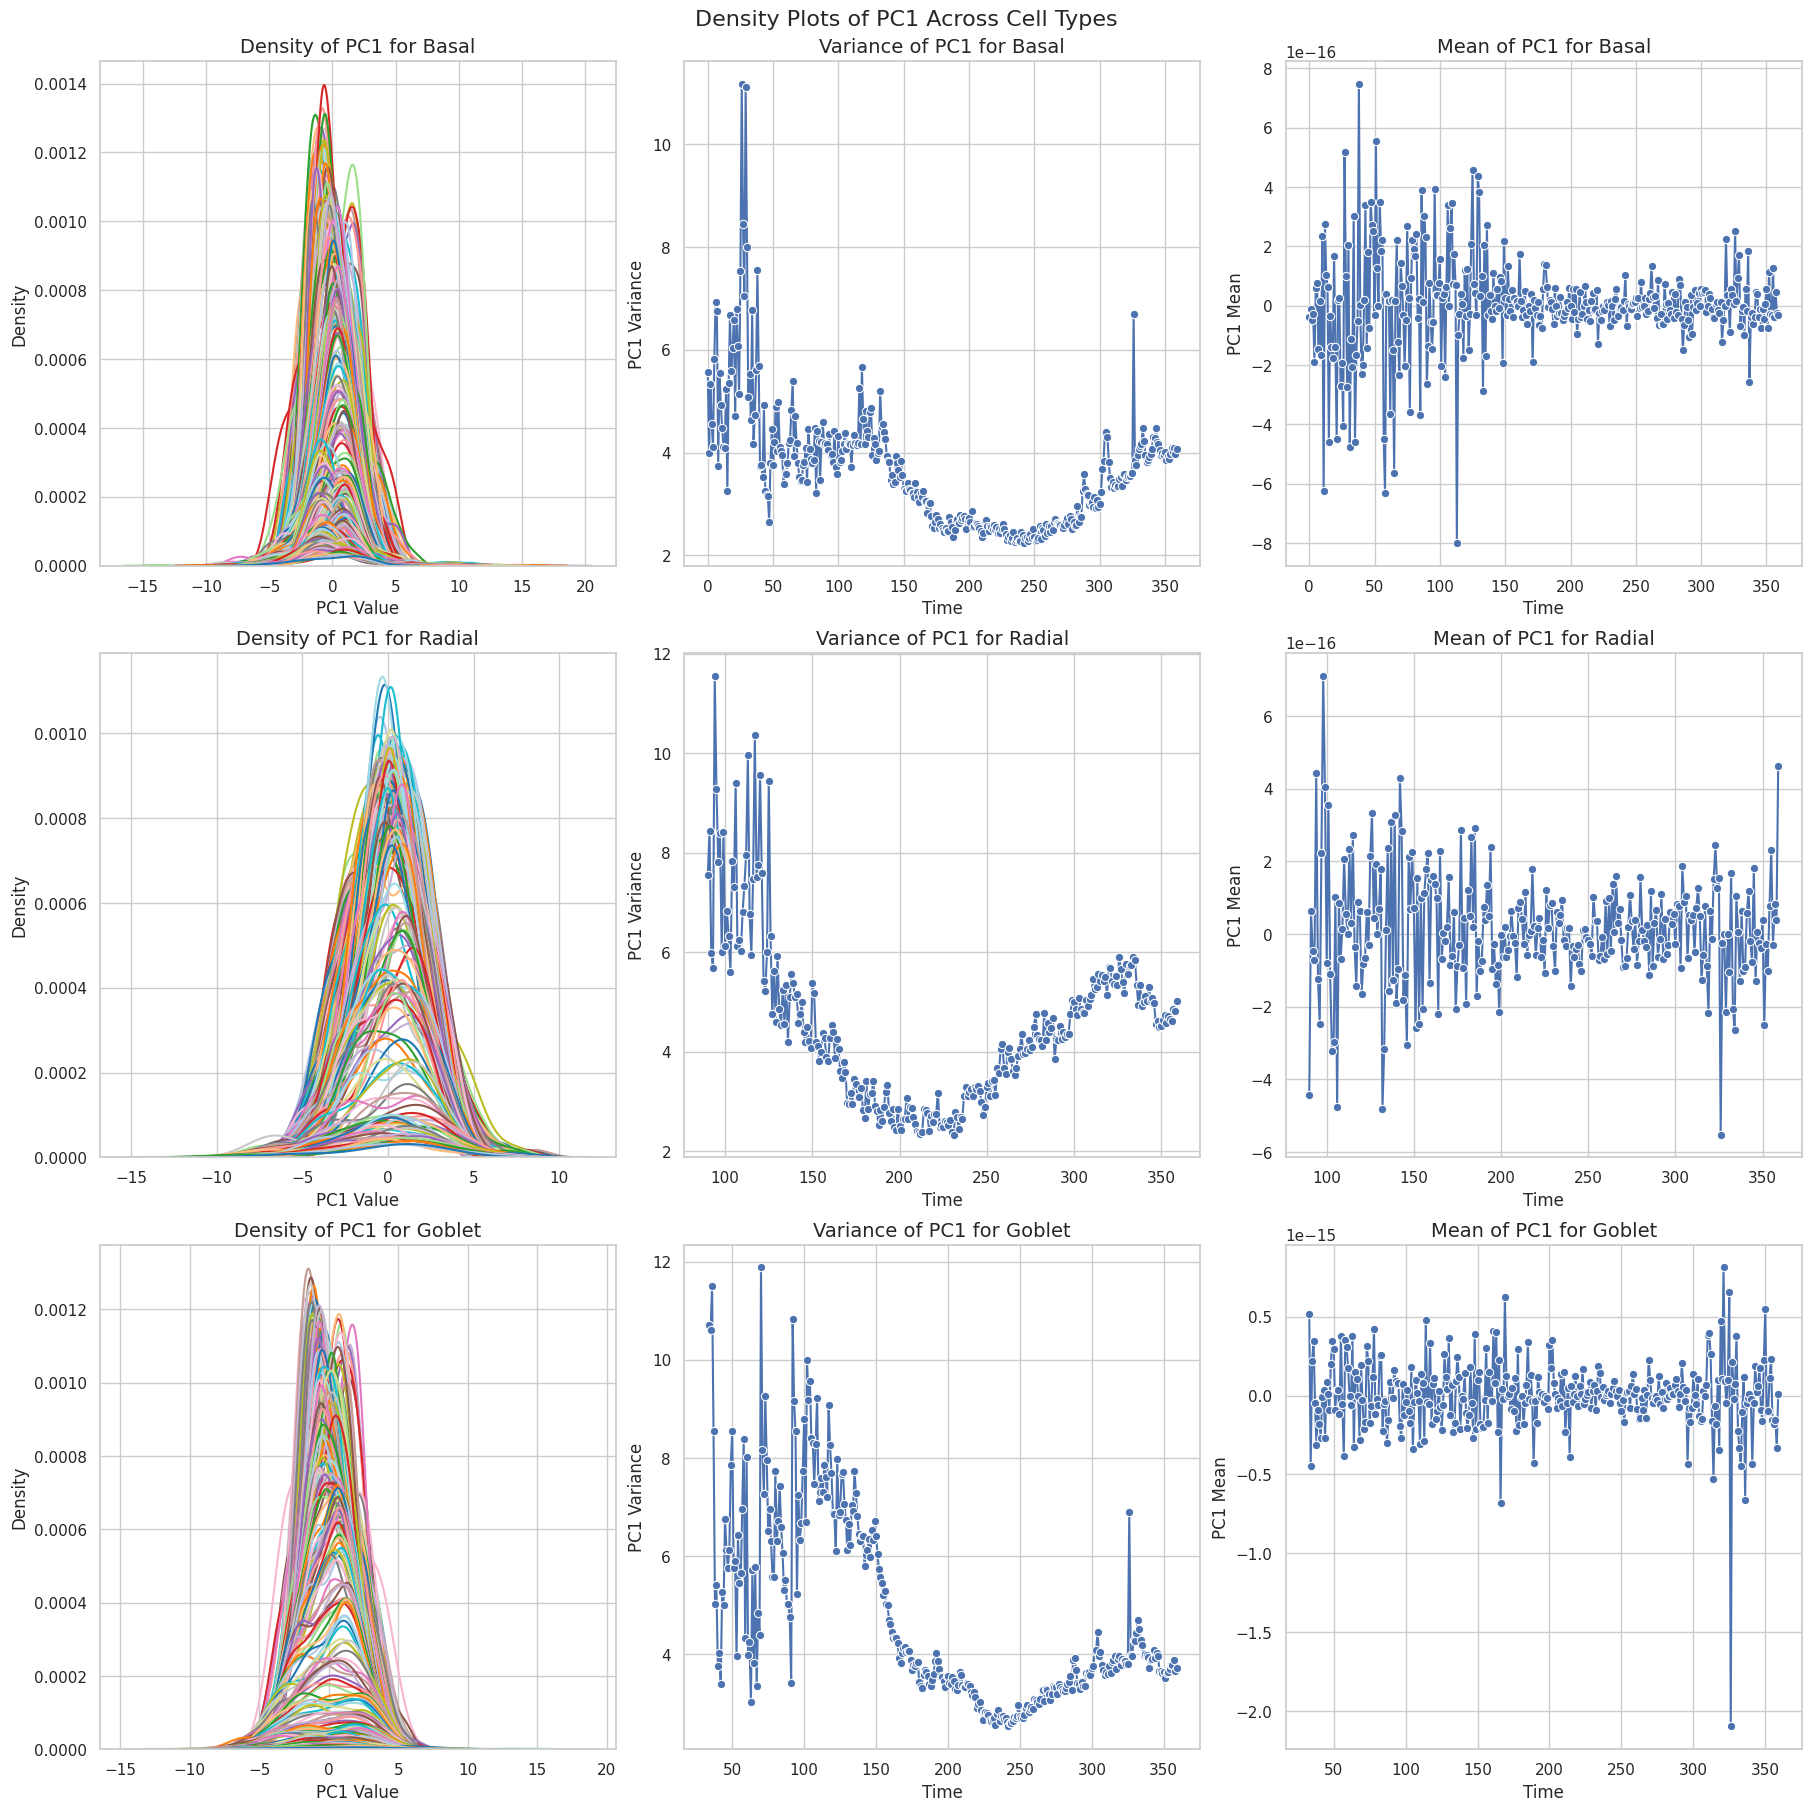

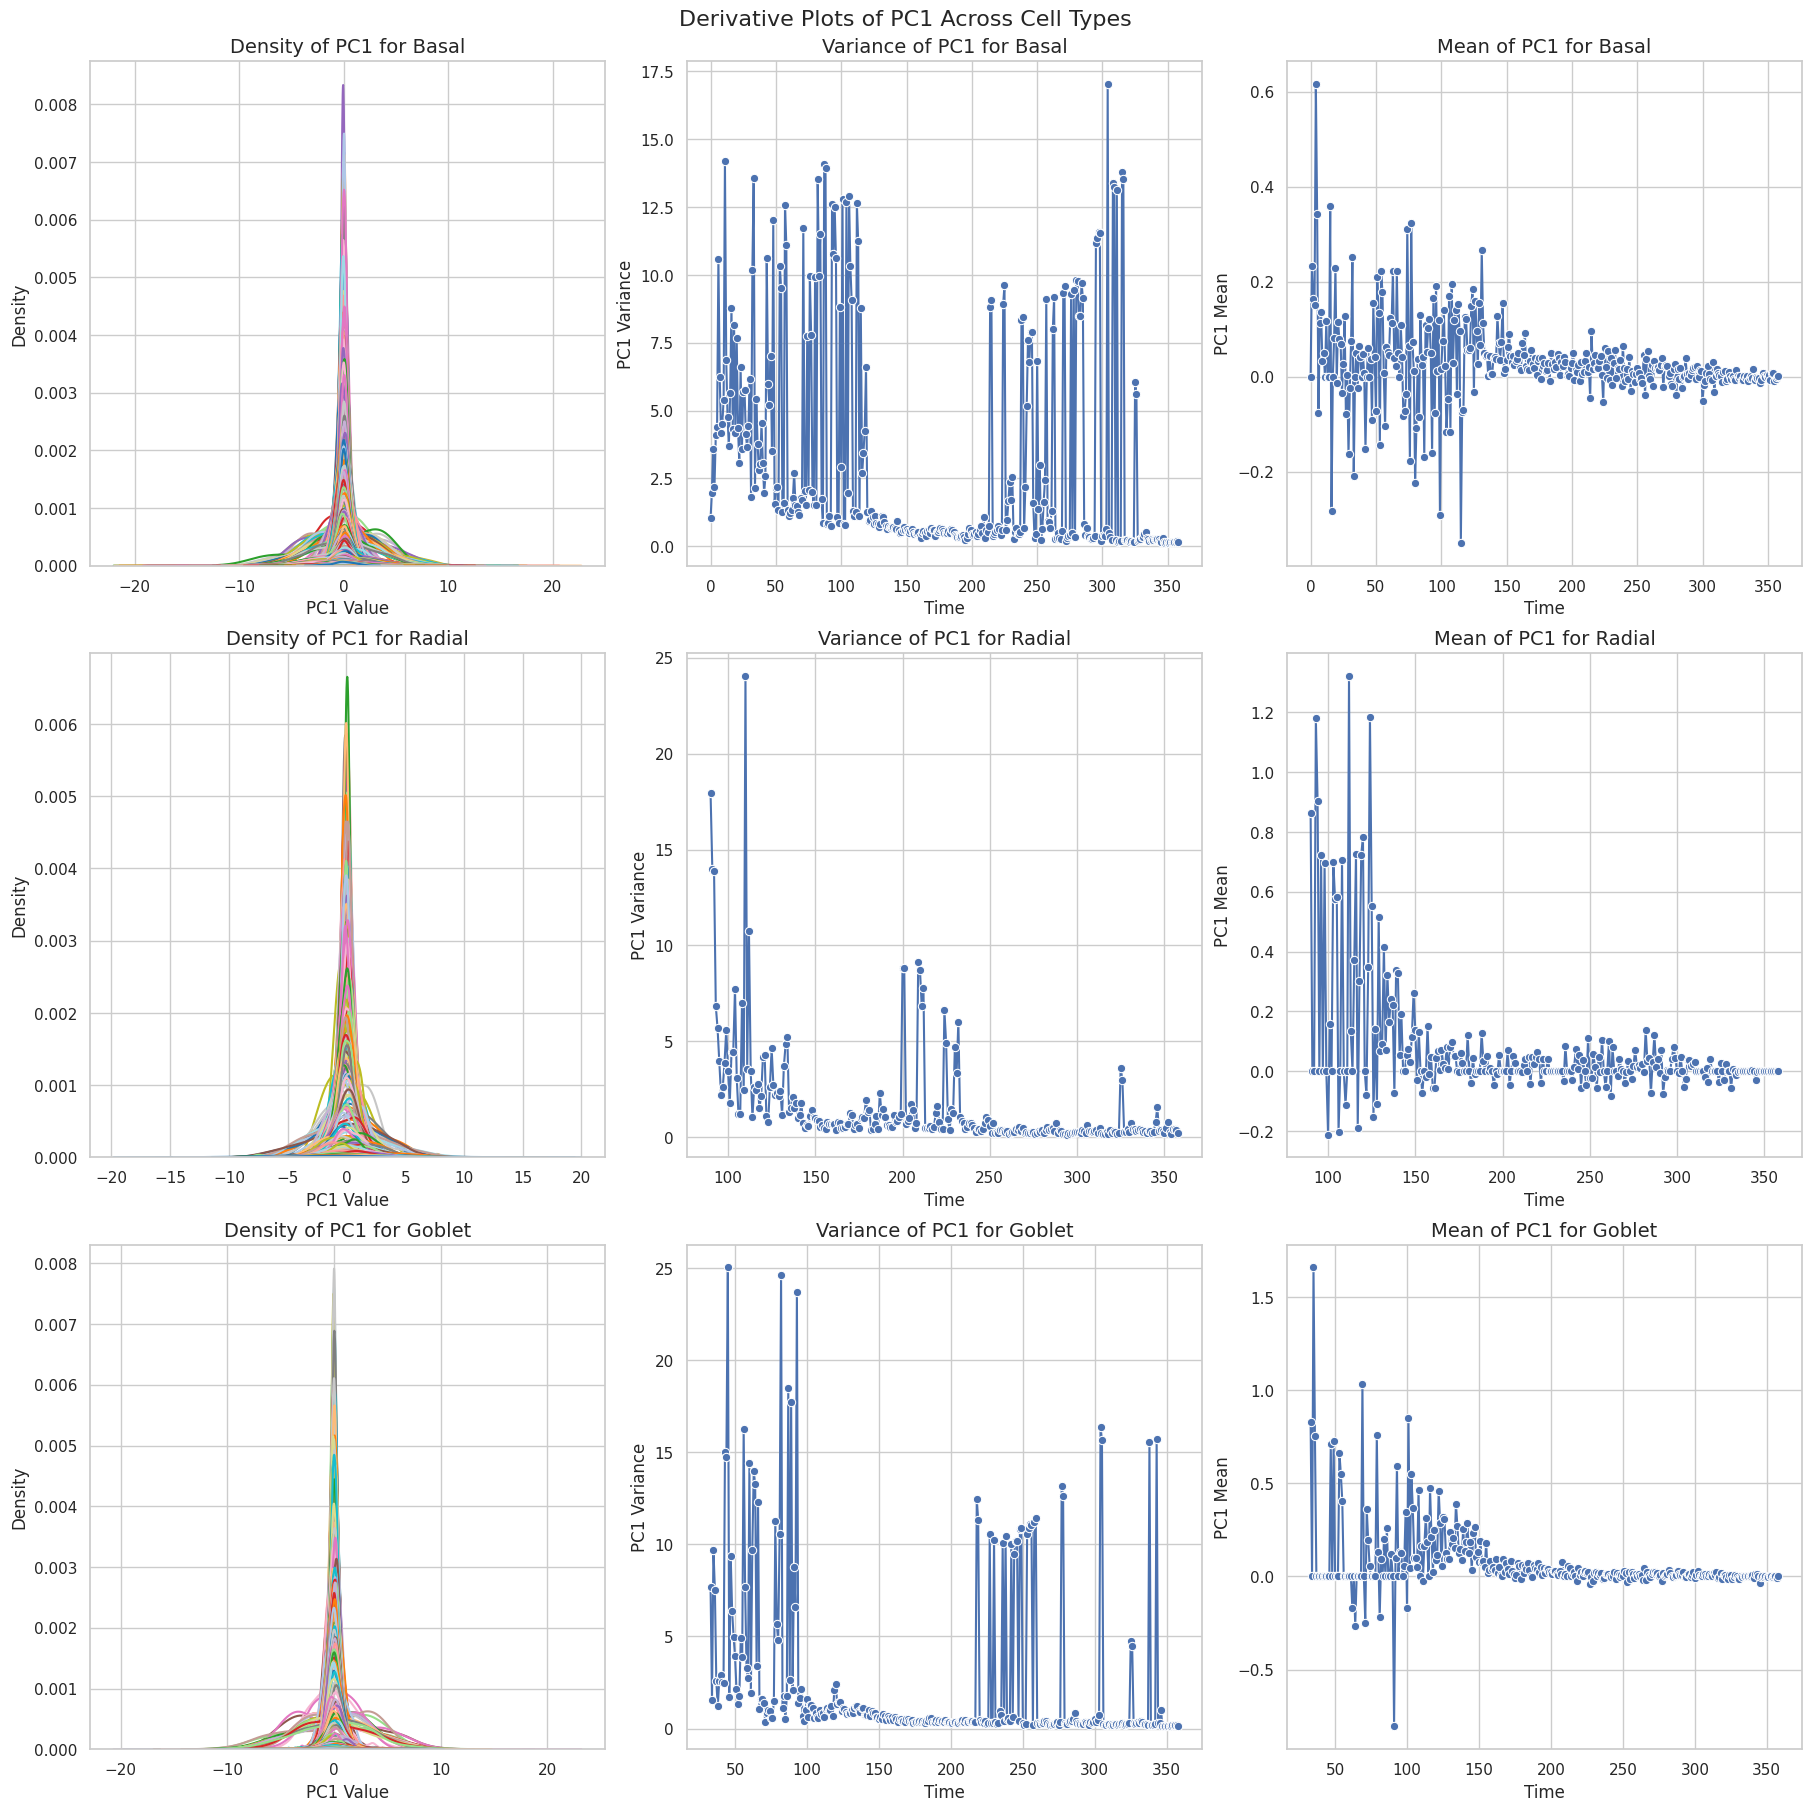

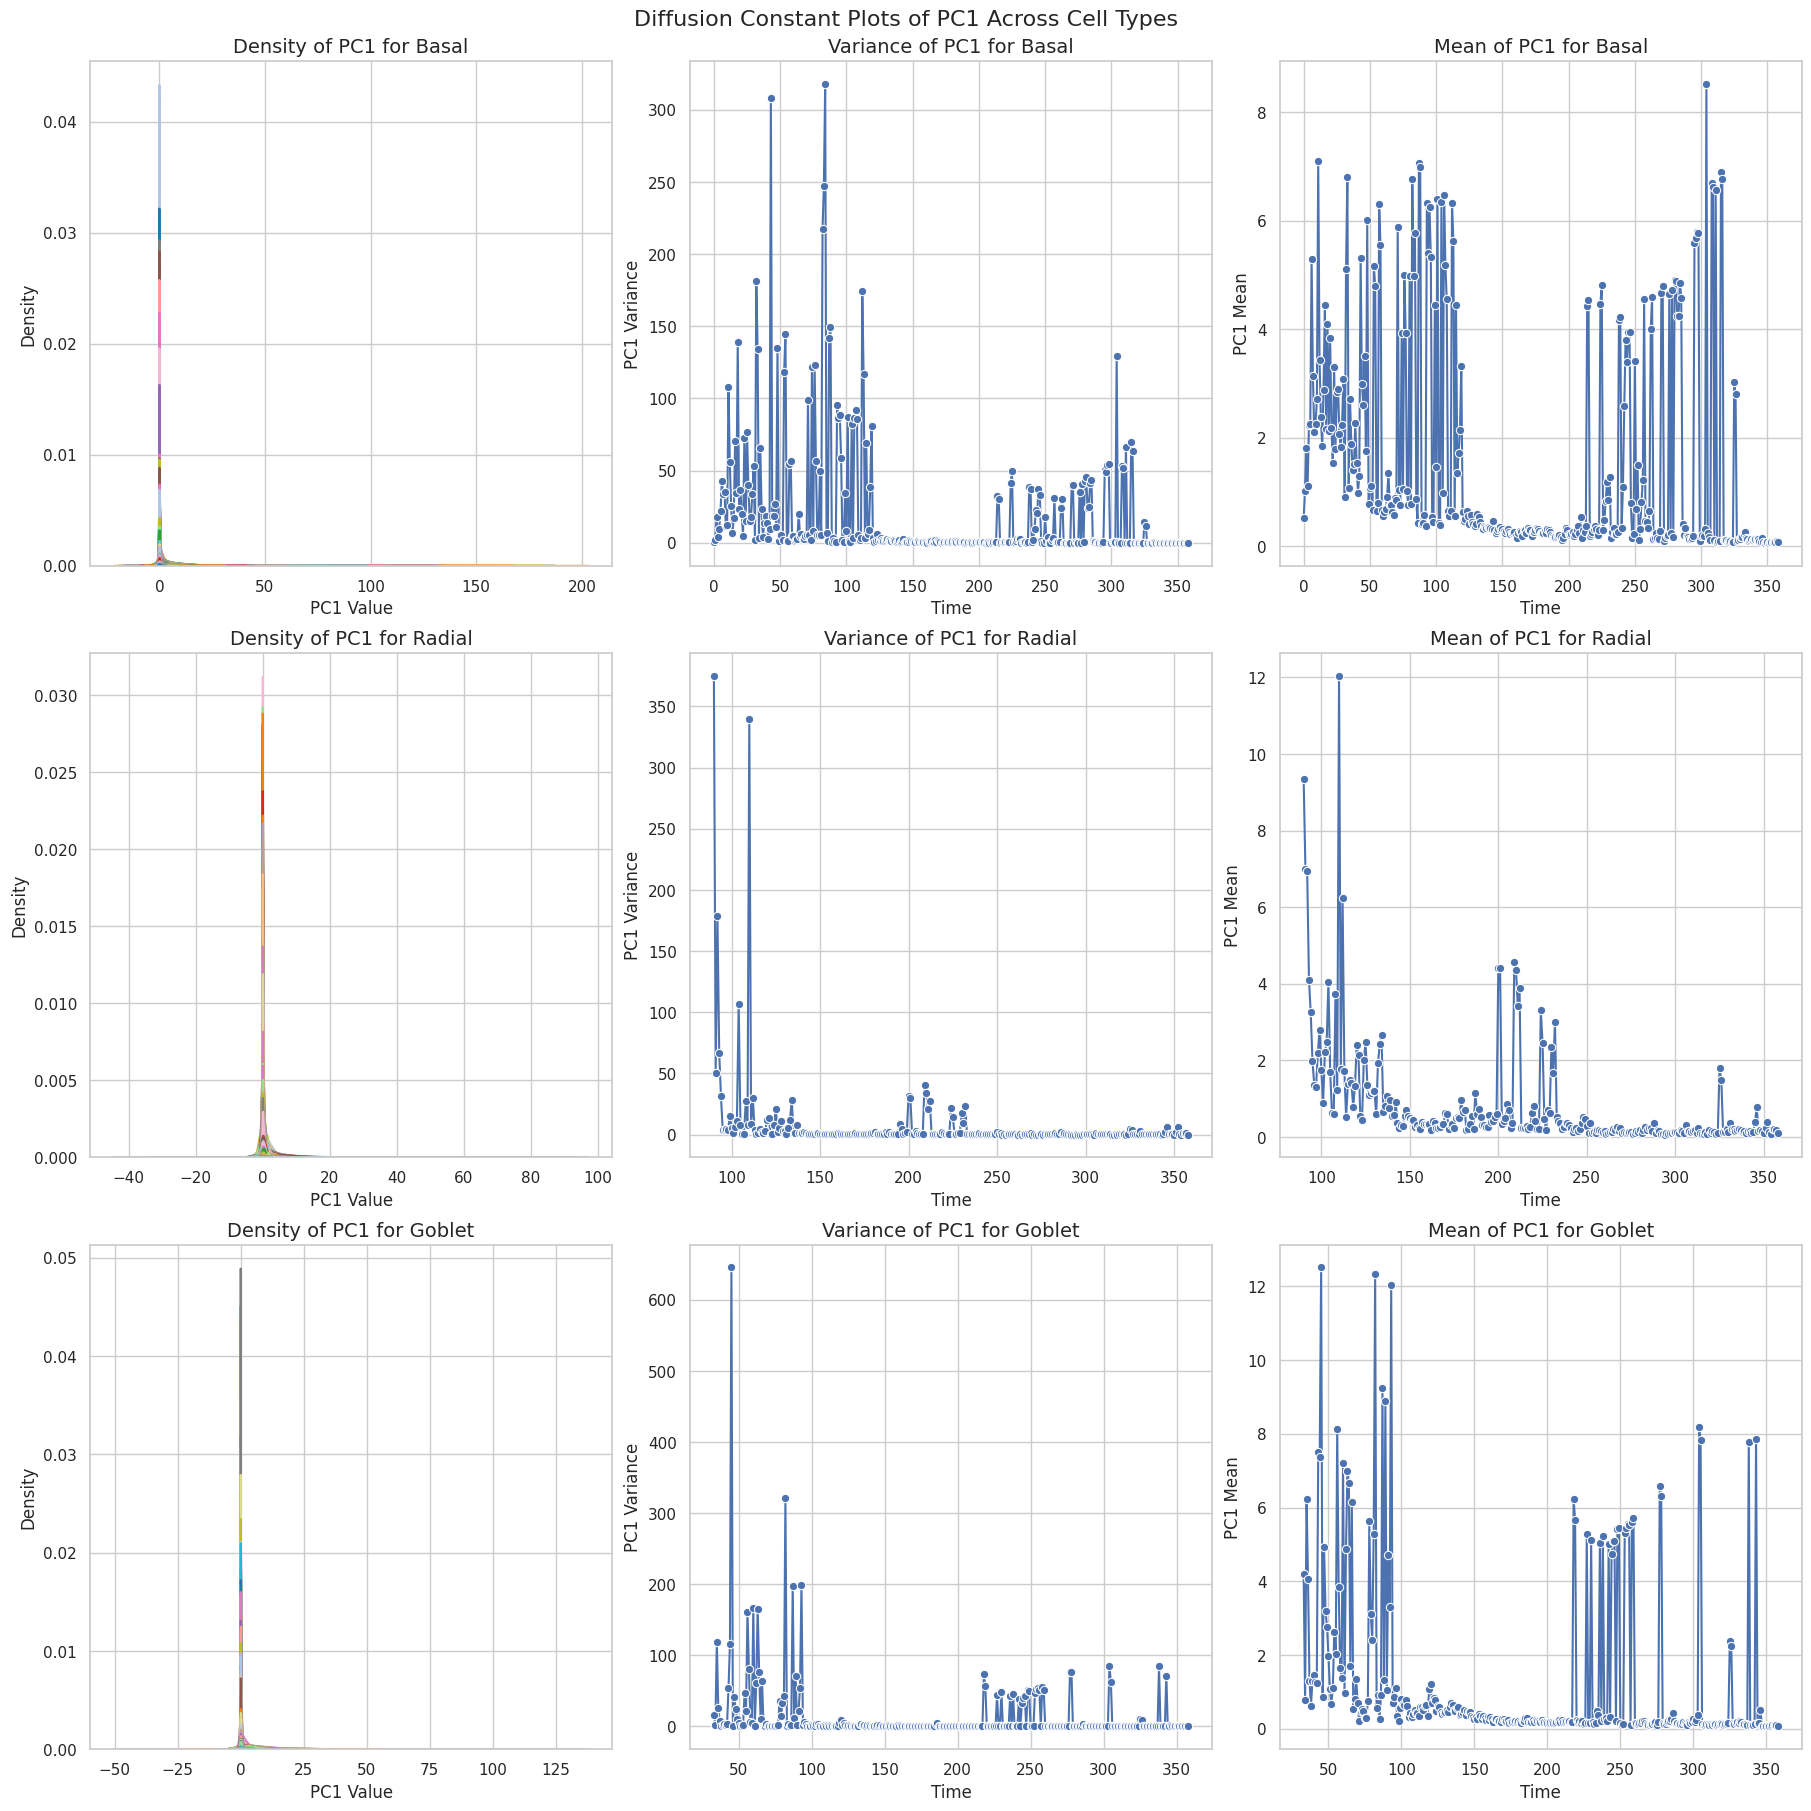

In [129]:
plot_pcs_density_and_stats(result_dict, class_map_gbr, n_components, title = 'Density Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_dict, class_map_gbr, n_components, title = 'Derivative Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_square_dict, class_map_gbr, n_components, title = 'Diffusion Constant Plots of PC1 Across Cell Types')




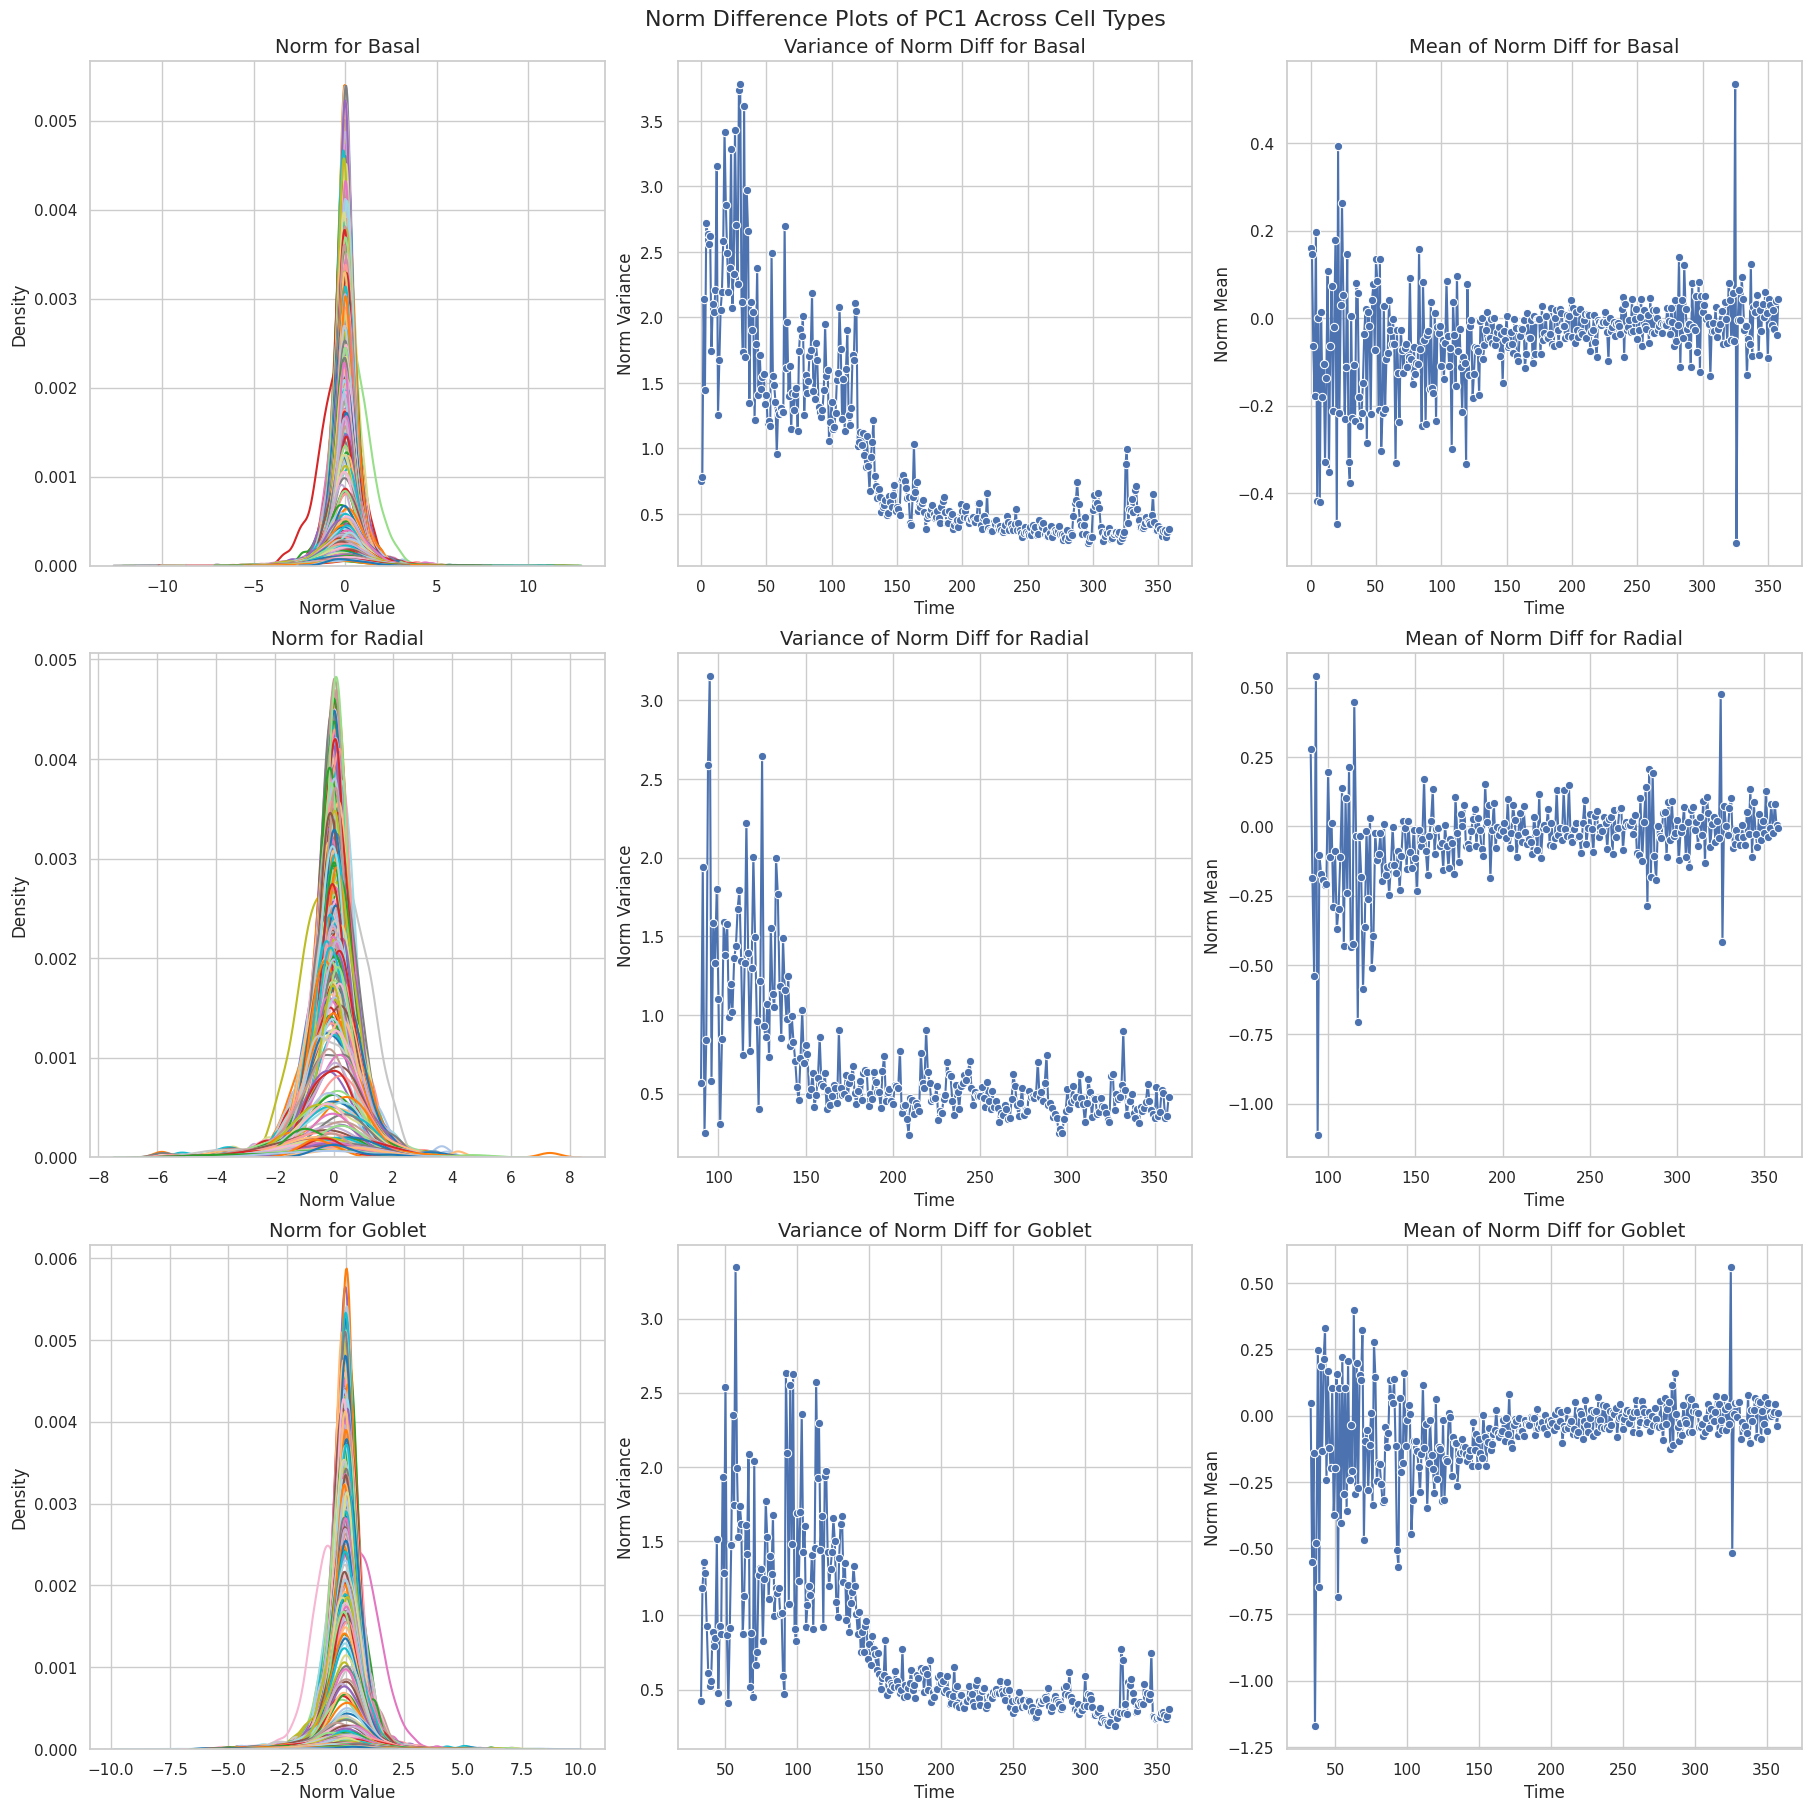

In [132]:
plot_norm_diff(norm_diff_dict, class_map_gbr, title = 'Norm Difference Plots of PC1 Across Cell Types')

In [ ]:
interactive_plot(result_dict, class_map_gbr, tracks_dataframe['t'].unique())